In [15]:
import pandas as pd
import numpy as np
from scipy.stats import norm

In [16]:
df1 = pd.read_csv("Datasets\options_prices.csv")
df = pd.read_csv("Datasets\stock_dataset.csv")

<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\adrie\AppData\Local\Temp\ipykernel_29624\1236474256.py:1: SyntaxWarning: invalid escape sequence '\o'
  df1 = pd.read_csv("Datasets\options_prices.csv")
C:\Users\adrie\AppData\Local\Temp\ipykernel_29624\1236474256.py:2: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv("Datasets\stock_dataset.csv")


In [17]:
dt = 1/252
r = 0.03

def estimate_parameters(df,t):
    # predict the price of an option based on information at time T
    df2 = df.iloc[0:t+1].copy()
    df2["log_St"] = np.log(df2['stock_price'])
    df2["D_log_St"] = df2["log_St"] - df2["log_St"].shift(1)

    sigma = np.sqrt(np.var(df2["D_log_St"][1:])/dt)
    mu = (sigma**2 / 2) + np.mean(df2["D_log_St"][1:])/dt 

    return(mu,sigma)

def compute_BS_price(K,T,t):
    mu, sigma = estimate_parameters(df,t)
    S0 = df.iloc[t]['stock_price']
    Dt = (T-t)/252
    d1 = (np.log(S0/K)+(r+sigma**2/2)*Dt)/(sigma*np.sqrt(Dt))
    d2 = d1 -sigma*np.sqrt(Dt)
    return(S0*norm.cdf(d1)-K*np.exp(-r*Dt)*norm.cdf(d2))

print(compute_BS_price(110,50,30))





0.9177125046337373


In [18]:
df1.head()

,date_created,strike,maturity,time_to_maturity,option_price
0,2025-01-01,80.0,2025-01-31,0.119048,20.209504
1,2025-01-01,80.0,2025-03-02,0.238095,20.833241
2,2025-01-01,80.0,2025-05-01,0.476190,21.206518
3,2025-01-01,85.0,2025-01-31,0.119048,15.073619
4,2025-01-01,85.0,2025-03-02,0.238095,15.749451


In [19]:

def market_day_number(date_str):
    return np.busday_count(f"{date_str[:4]}-01-01", date_str) + 1

df1['date_created_nb'] = df1['date_created'].apply(market_day_number)
df1['maturity_nb'] = df1['maturity'].apply(market_day_number)

In [20]:
def add_BS_price_df(row):
    K = row['strike']
    T = row['maturity_nb']
    t = row['date_created_nb']
    row['estimated_price'] = compute_BS_price(K,T,t) 
    return(row)

df_pred = df1[df1['date_created_nb']>20].copy()
df_pred = df_pred.apply(add_BS_price_df, axis = 1)


In [ ]:
df_pred['relative_error'] = np.where(
    df_pred['option_price'] != 0,
    np.abs(100 * (df_pred['estimated_price'] - df_pred['option_price']) / df_pred['option_price']),
    0
)



df_pred = df_pred.merge(df[['date', 'stock_price']], 
                left_on='date_created', right_on='date', 
                how='left')

df_pred = df_pred.drop(columns=['date'])

In [ ]:
df_pred[:10]

,date_created,strike,maturity,time_to_maturity,option_price,date_created_nb,maturity_nb,estimated_price,relative_error,date,stock_price
0,2025-01-29,80.0,2025-02-28,0.119048,18.008312,21,43,17.357875,3.611871,2025-01-29,98.088392
1,2025-01-29,80.0,2025-03-30,0.238095,18.372718,21,64,17.609168,4.155890,2025-01-29,98.088392
2,2025-01-29,80.0,2025-05-29,0.476190,19.036072,21,107,18.292920,3.903918,2025-01-29,98.088392
3,2025-01-29,85.0,2025-02-28,0.119048,13.531121,21,43,12.420375,8.208828,2025-01-29,98.088392
4,2025-01-29,85.0,2025-03-30,0.238095,13.555140,21,64,12.859157,5.134460,2025-01-29,98.088392
5,2025-01-29,85.0,2025-05-29,0.476190,14.861628,21,107,13.901871,6.457955,2025-01-29,98.088392
6,2025-01-29,90.0,2025-02-28,0.119048,8.445779,21,43,7.768521,8.018900,2025-01-29,98.088392
7,2025-01-29,90.0,2025-03-30,0.238095,9.424215,21,64,8.572087,9.041901,2025-01-29,98.088392
8,2025-01-29,90.0,2025-05-29,0.476190,10.616239,21,107,10.030705,5.515459,2025-01-29,98.088392
9,2025-01-29,95.0,2025-02-28,0.119048,4.457461,21,43,3.978272,10.750275,2025-01-29,98.088392


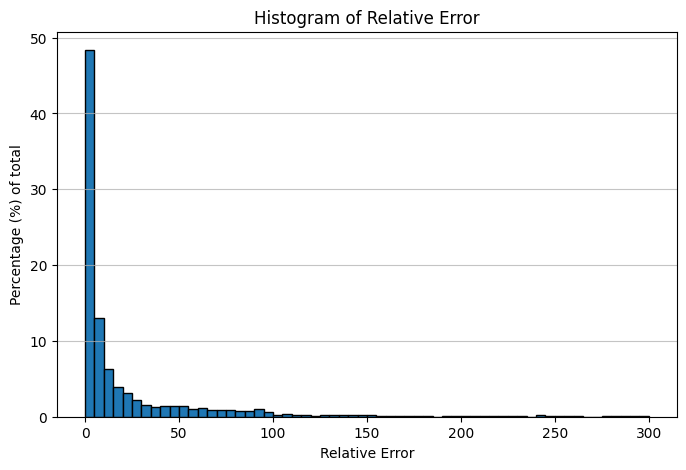

In [23]:
import matplotlib.pyplot as plt


errors = df_pred['relative_error']
errors_clean = errors[np.isfinite(errors)]
errors_filtered = errors_clean[(errors_clean >= 0) & (errors_clean <= 300)]


total_count = len(errors_clean)

bins = np.arange(0, 305, 5)

plt.figure(figsize=(8,5))
plt.hist(errors_filtered, bins=bins, weights=np.ones_like(errors_filtered) / total_count * 100,
         edgecolor='black')

plt.xlabel('Relative Error')
plt.ylabel('Percentage (%) of total')
plt.title('Histogram of Relative Error')
plt.grid(axis='y', alpha=0.75)
plt.show()